# Classification of weather data


One idea of the project was to investigate whether a typical weather situation lead to an increased usage of cars as a mode of transport. The hypothesis was that e.g. good weather makes people want to have some more fresh air and go by bike or foot, while on rainy days people feel more comfortable in their own car.

To make the data available more manageable in terms of running a model with it, a classification of the weather data was created.

**Good weather** —> might go by bike oder foot
- Sunny (> 50 % of max sunshine duration)
- Calm (< 1.5 m/s)
- Dry (< 1 mm precipitation)  
- Warm (> 15 degree C)

**Bad weather** —> might prefer to go by car

- Rainy (> 5 mm)
- Windy (> 8 m/s)
- Cold (< 5 degree C)

**Driving unfriendly weather** —> might go by public transport or stay at home
- Snow (< 1 degree C and precipitation)
- Ice

**Neutral** —> Everything else

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
from calendar import monthrange
from calendar import month_name
import matplotlib.patches as patches

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
import matplotlib.dates as mdates

%matplotlib inline

# Plot formatting
# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

warnings.filterwarnings('ignore')

In [3]:
holidays = pd.read_csv('../data/holiday_event_final.csv')
weather = pd.read_csv('../data/df_weather_daily.csv',index_col=0,parse_dates=True)
#anomalies = pd.read_csv('../data/anomalies-testdata.csv',index_col=0, parse_dates=True)


The weather data contains several meteorological variables.


In [3]:
weather.head()


,wind_dir,sun_minutes,rel_humid,cloud_cover,t_air,t_surface,precip,wind_speed,day_minutes,sunrise,sunset,sun_time_fraction
date,,,,,,,,,,,,
2012-01-01,186.759583,1.0,91.799167,7.482500,9.535000,7.262083,0.0,3.091667,452.033333,2012-01-01 07:36:33,2012-01-01 15:08:35,0.002212
2012-01-02,241.788333,0.0,84.746250,5.486250,8.412083,5.536667,0.0,3.900417,453.066667,2012-01-02 07:36:31,2012-01-02 15:09:35,0.000000
2012-01-03,204.218333,29.0,84.026667,5.520000,5.700000,2.941250,8.8,6.207500,454.350000,2012-01-03 07:36:21,2012-01-03 15:10:42,0.063827
2012-01-04,240.048333,49.0,79.091667,6.512500,5.432500,2.882917,7.0,6.447500,455.600000,2012-01-04 07:36:11,2012-01-04 15:11:47,0.107550
2012-01-05,263.371667,12.0,80.092083,7.052083,6.114167,4.136667,15.7,7.737500,457.100000,2012-01-05 07:35:54,2012-01-05 15:13:00,0.026252


The attribute "weather class" ist created.

In [ ]:
#create attribute "weather_class"

# good weather = 1
# - Dry (< 1 mm precipitation)  
# - Warm (> 10 degree C)

# bad weather = 2
# - Rainy (> 5 mm)
# - Cold (< 10 degree C)

# driving unfriendly weather = 3
# - Snow (< 1.5 degree C and precipitation)
# - Ice

# neutral = 0


weather.loc[(weather.precip <= 1) & (weather.t_air >= 10), 'weather_class'] = '1'
weather.loc[(weather.precip > 1) & (weather.t_air < 10) & (weather.t_air > 1.5), 'weather_class'] = '2'
weather.loc[(weather.precip >= 1) & (weather.t_air <= 1.5), 'weather_class'] = '3'

weather['weather_class'] = weather['weather_class'].fillna('0')


In [8]:
weather.weather_class.value_counts()
weather.info()

weather.to_csv("../data/weather_classes.csv")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2012-01-01 to 2022-12-31
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_dir           4002 non-null   float64
 1   sun_minutes        4018 non-null   float64
 2   rel_humid          4017 non-null   float64
 3   cloud_cover        3992 non-null   float64
 4   t_air              4011 non-null   float64
 5   t_surface          3967 non-null   float64
 6   precip             4018 non-null   float64
 7   wind_speed         4002 non-null   float64
 8   day_minutes        4018 non-null   float64
 9   sunrise            4018 non-null   object 
 10  sunset             4018 non-null   object 
 11  sun_time_fraction  4018 non-null   float64
 12  weather_class      4018 non-null   object 
dtypes: float64(10), object(3)
memory usage: 439.5+ KB


## Create dataframe with traffic anomalies

Now the weather data is concatenated with the traffic data frame. This data frame can then be used for correlation analysis.

In [9]:
### weather and anomalies
weather = weather.loc[:'1/1/2019']

In [10]:
weather['dates'] = weather.index.date.astype(str)

In [11]:
anomalies['dates'] = anomalies.index.date.astype(str)
anomalies.reset_index(inplace=True)

In [12]:
anom_weath = anomalies.merge(weather,left_on='dates',right_on='dates',how='outer')

In [13]:
anom_weath.dropna(subset='datetime',inplace=True)

In [14]:
anom_weath.head()

,datetime,Z1061,Z1077,Z1061_tdiff_7day,Z1077_tdiff_7day,Z1061_anoms_day,Z1077_anoms_day,Z1061_proph-resid,Z1077_proph-resid,dates,...,cloud_cover,t_air,t_surface,precip,wind_speed,day_minutes,sunrise,sunset,sun_time_fraction,weather_class
0,2012-11-08,51557.0,35134.0,NaN,NaN,3465.0,1912.0,-337.0,1096.0,2012-11-08,...,7.325833,9.385909,NaN,1.3,4.413333,545.650000,2012-11-08 06:30:47,2012-11-08 15:36:26,0.000000,2
1,2012-11-09,52399.0,35077.0,NaN,NaN,4090.0,1391.0,317.0,505.0,2012-11-09,...,7.158750,8.996250,NaN,0.0,2.740000,542.016667,2012-11-09 06:32:40,2012-11-09 15:34:41,0.000000,0
2,2012-11-10,42448.0,31288.0,NaN,NaN,4895.0,3546.0,1609.0,2958.0,2012-11-10,...,6.508750,7.924167,NaN,3.8,2.528333,538.300000,2012-11-10 06:34:36,2012-11-10 15:32:54,0.050158,2
3,2012-11-11,NaN,24325.0,NaN,NaN,NaN,459.0,NaN,-16.0,2012-11-11,...,4.082917,9.782000,NaN,0.2,2.447917,534.750000,2012-11-11 06:36:28,2012-11-11 15:31:13,0.364656,0
4,2012-11-12,49908.0,32503.0,NaN,NaN,4040.0,1511.0,54.0,652.0,2012-11-12,...,4.589167,NaN,NaN,0.0,2.460417,531.133333,2012-11-12 06:38:23,2012-11-12 15:29:31,0.080959,0


In [15]:
df = anom_weath[['Z1061', 'Z1077', 'Z1061_tdiff_7day', 'Z1077_tdiff_7day',
       'Z1061_anoms_day', 'Z1077_anoms_day', 'Z1061_proph-resid',
       'Z1077_proph-resid', 'weather_class']].copy()

A visualisation of the distribution of traffic according to the weather classified days gives a first overview.

''

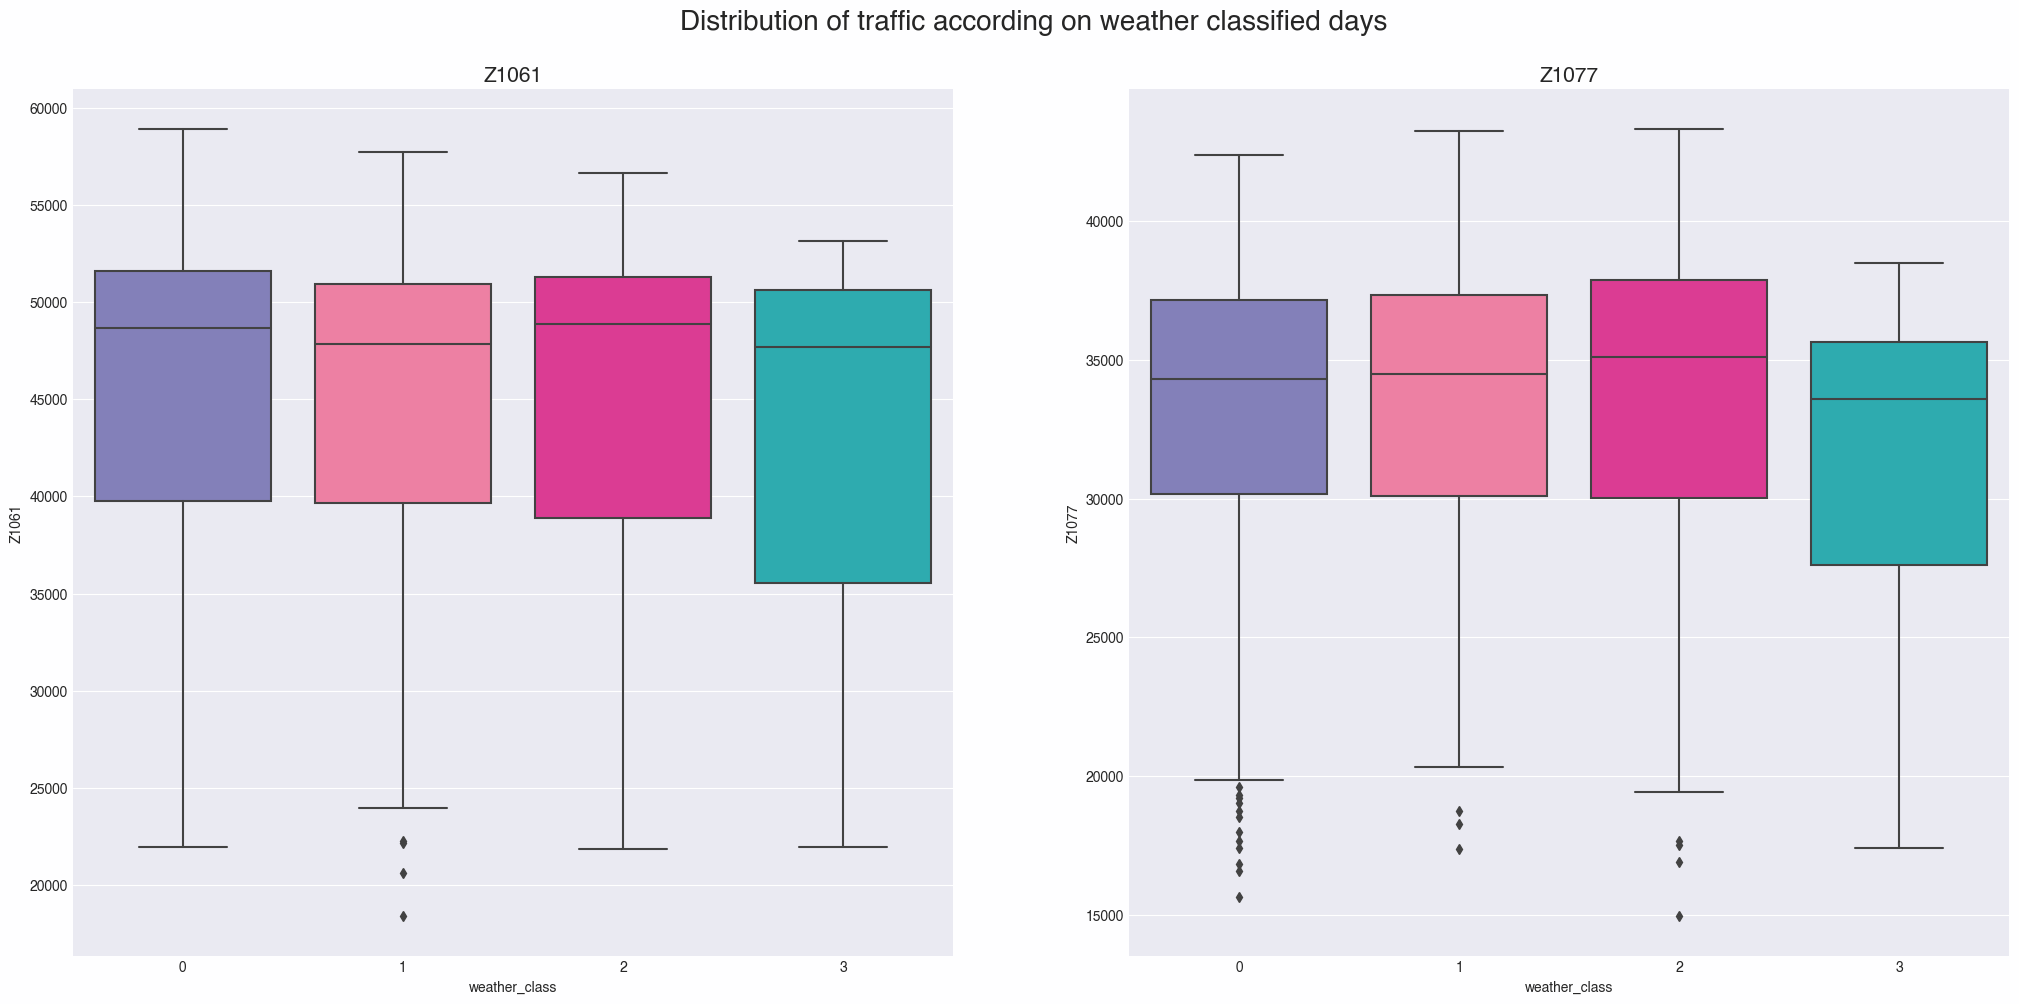

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,10)) # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of traffic according on weather classified days', fontsize=20)
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

sns.boxplot(x="weather_class", y="Z1061", data=df, order=['0', '1', '2', '3'], ax=ax[0])
sns.boxplot(x="weather_class", y="Z1077", data=df, order=['0', '1', '2', '3'], ax=ax[1])
ax[0].set_title("Z1061", fontsize = 15); # sets title for subplot
ax[1].set_title("Z1077", fontsize = 15); # sets title for subplot
;



''

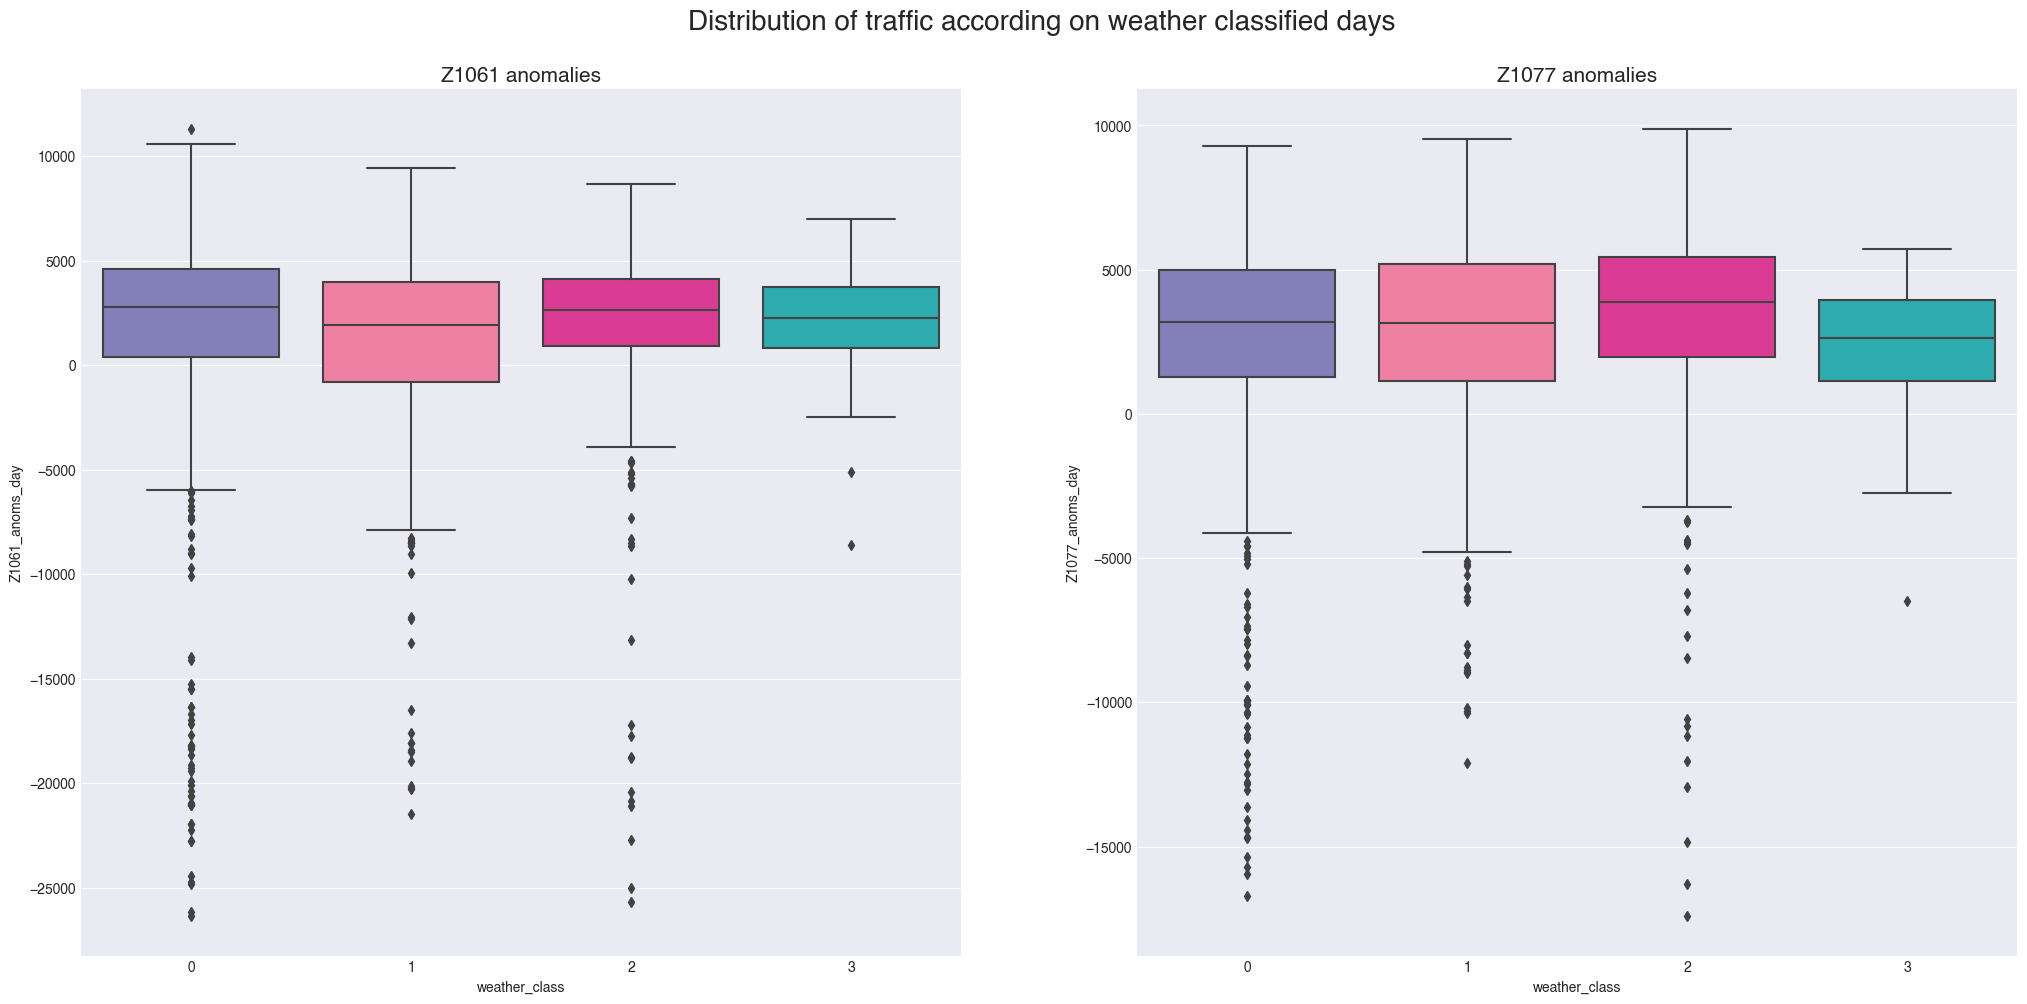

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,10)) # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of traffic according on weather classified days', fontsize=20)
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

sns.boxplot(x="weather_class", y="Z1061_anoms_day", data=df, order=['0', '1', '2', '3'], ax=ax[0])
sns.boxplot(x="weather_class", y="Z1077_anoms_day", data=df, order=['0', '1', '2', '3'], ax=ax[1])
ax[0].set_title("Z1061 anomalies", fontsize = 15); # sets title for subplot
ax[1].set_title("Z1077 anomalies", fontsize = 15); # sets title for subplot
;


''

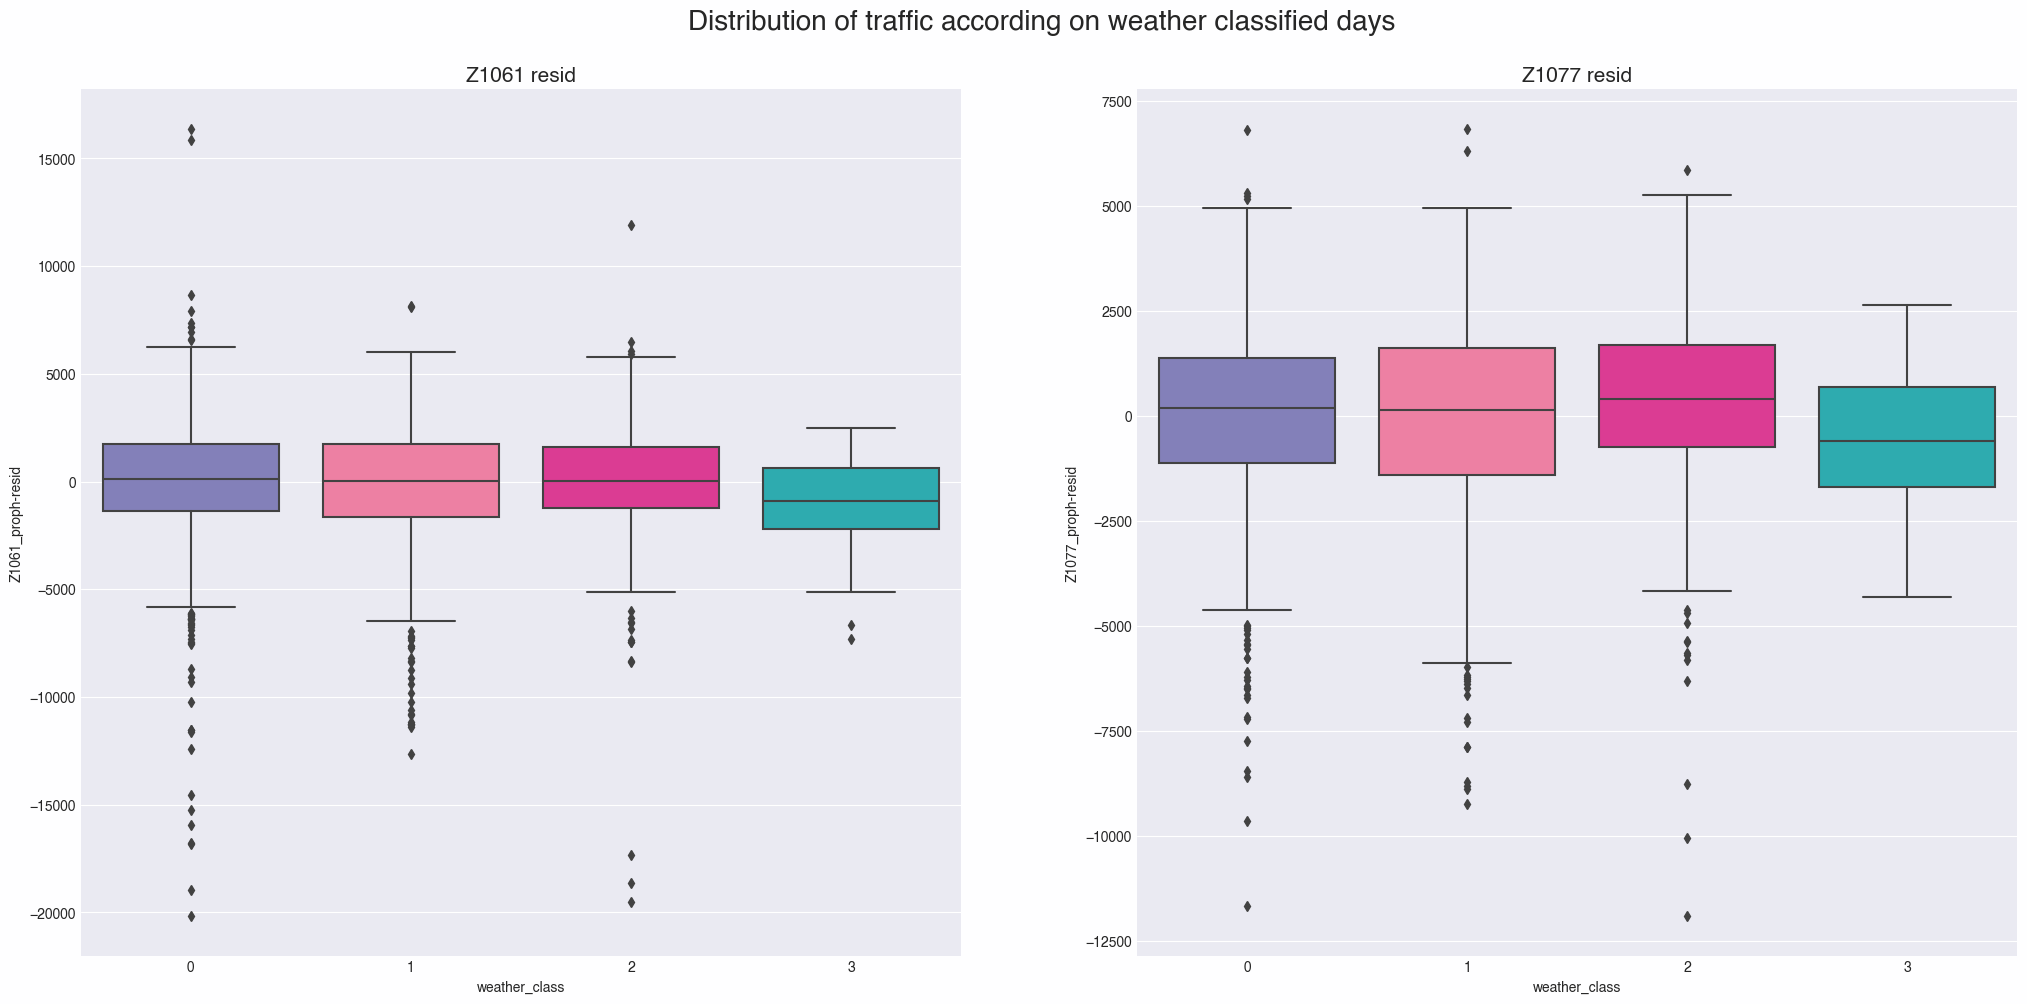

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20,10)) # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of traffic according on weather classified days', fontsize=20)
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

sns.boxplot(x="weather_class", y="Z1061_proph-resid", data=df, order=['0', '1', '2', '3'], ax=ax[0])
sns.boxplot(x="weather_class", y="Z1077_proph-resid", data=df, order=['0', '1', '2', '3'], ax=ax[1])
ax[0].set_title("Z1061 resid", fontsize = 15); # sets title for subplot
ax[1].set_title("Z1077 resid", fontsize = 15); # sets title for subplot
;

Despite personal experience and common sense there appears to be no relation between the traffic density an weather conditions.